# Développez un moteur de recommandations de films

## Récupération et visualisation des données

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, decomposition, metrics, cluster
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 200)
np.set_printoptions(precision=5, suppress=True)
plt.style.use('default')

In [2]:
# Méthode de suppression de colonne
def DropCol(p_df, p_col):
    if p_col in p_df.columns:
        p_df = p_df.drop([p_col], axis=1)
    return p_df

In [3]:
# Récupération du fichier en local
df = pd.read_csv('movie_metadata_cleaned.csv', sep="\t", encoding='utf-8')
df.tail()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
4914,1,Scott Smith,1.0,87.0,2.0,318.0,Daphne Zuniga,637.0,25035665.0,Comedy|Drama,Eric Mabius,Signed Sealed Delivered,629,2283.0,Crystal Lowe,2.0,fraud|postal worker|prison|theft|trial,6.0,English,Canada,R,19900000.0,2013.0,470.0,7.7,2.00,84
4915,1,NaN,43.0,43.0,48.0,319.0,Valorie Curry,841.0,25035665.0,Crime|Drama|Mystery|Thriller,Natalie Zea,The Following,73839,1753.0,Sam Underwood,1.0,cult|fbi|hideout|prison escape|serial killer,359.0,English,USA,TV-14,19900000.0,2009.0,593.0,7.5,16.00,32000
4916,1,Benjamin Roberds,13.0,76.0,0.0,0.0,Maxwell Moody,0.0,25035665.0,Drama|Horror|Thriller,Eva Boehnke,A Plague So Pleasant,38,0.0,David Chandler,0.0,NaN,3.0,English,USA,R,1400.0,2013.0,0.0,6.3,2.00,16
4917,1,Daniel Hsia,14.0,100.0,0.0,489.0,Daniel Henney,946.0,10443.0,Comedy|Drama|Romance,Alan Ruck,Shanghai Calling,1255,2386.0,Eliza Coupe,5.0,NaN,9.0,English,USA,PG-13,19900000.0,2012.0,719.0,6.3,2.35,660
4918,1,Jon Gunn,43.0,90.0,16.0,16.0,Brian Herzlinger,86.0,85222.0,Documentary,John August,My Date with Drew,4285,163.0,Jon Gunn,0.0,actress name in title|crush|date|four word tit...,84.0,English,USA,PG,1100.0,2004.0,23.0,6.6,1.85,456


## Matrice de corrélation

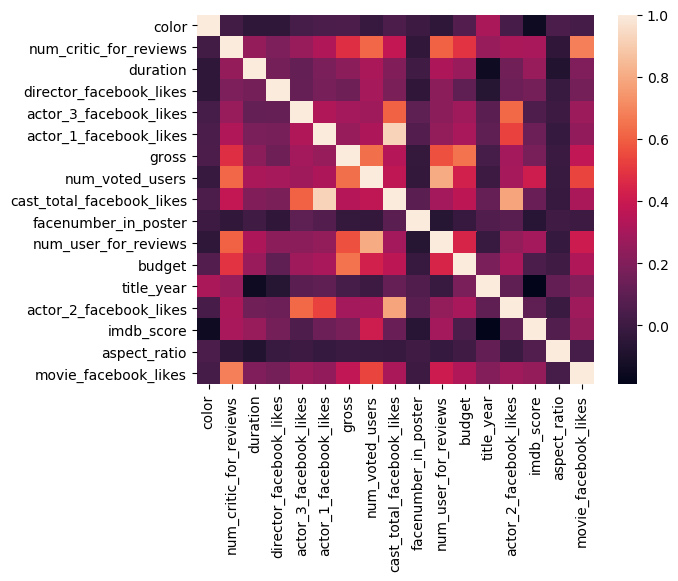

In [4]:
#Correlation Heat Map
import seaborn as sns
sns.heatmap(df.corr())

## Transformations

### Quelques méthodes

In [5]:
# Méthode de création d'une colonne avec tous les mots clés
KEYWORDSCOL = 'all_keywords'
def CreateCol(p_df, p_cols):
    dfnotnull = p_df.fillna('')
    tmp = ""
    for col in p_cols:
        if len(tmp) > 0:
            tmp += '|'
        tmp += dfnotnull[col]
    #p_df = p_df.assign(all_keywords=tmp)
    ret = pd.DataFrame({KEYWORDSCOL : tmp})
    return ret

In [6]:
# Méthode pour nettoyer une matrice
# Comme on a créé beaucoup de colonnes on supprime celles qui n'ont qu'un seul représentant
def CleanTable(p_df):
    i = 0
    col_to_remove = []
    for col in p_df.columns:
        if p_df[col].sum() == 1:
            col_to_remove.append(col)
            i += 1
            continue
        # Et la colonne sans clé
        if col == 'key_':
            col_to_remove.append(col)
            i += 1
    print(i, 'colonnes supprimées')
    p_df = p_df.drop(col_to_remove, axis=1)
    print(p_df.shape)
    return p_df

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
def token(text):
    return(text.split('|'))

def CreateTable(p_df, p_cols):
    # Création d'une colonne avec tous les mots clés
    col_keywords = CreateCol(df[cols], cols)
    cv = CountVectorizer(tokenizer=token)
    cv.fit_transform(col_keywords[KEYWORDSCOL])
    lst = cv.get_feature_names()
    # Création d'une table avec une colonne pour chaque mot clé
    ret = pd.DataFrame(cv.transform(col_keywords[KEYWORDSCOL]).toarray(), index=p_df.index)
    ret = ret.rename(columns = lambda x: "key_"+lst[x])
    # Suppression des colonnes utilisée une seule fois
    ret = CleanTable(ret)
    return ret

### Transformations des colonnes non numériques

In [8]:
# Création d'une colonne avec tous les mots clés de la colonne 'genres'
cols = ['genres']
dfkeys1 = CreateTable(df[cols], cols)

# On peut aussi mettre d'autres mots clés mais pas trop
cols = ['genres', 'director_name', 'actor_1_name', 'language', 'movie_title']
dfkeys2 = CreateTable(df[cols], cols)

# On peut tester avec tous les mots clés
cols = ['genres', 'plot_keywords', 'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'language', 'country', 'content_rating', 'movie_title']
dfkeys3 = CreateTable(df[cols], cols)

1 colonnes supprimées
(4919, 25)
7765 colonnes supprimées
(4919, 1651)
14831 colonnes supprimées
(4919, 6454)


In [9]:
# Création des matrices avec de plus en plus d'information
df_num = df.select_dtypes(include=[np.number])
df_num1 = pd.concat([df_num, dfkeys1], axis=1)
print (df_num1.shape)
df_num2 = pd.concat([df_num, dfkeys2], axis=1)
print (df_num2.shape)
df_num3 = pd.concat([df_num, dfkeys3], axis=1)
print (df_num3.shape)

(4919, 42)
(4919, 1668)
(4919, 6471)


In [10]:
# Normalisation
X_norm1 = preprocessing.scale(df_num1)
print (X_norm1.shape)
X_norm2 = preprocessing.scale(df_num2)
print (X_norm2.shape)
X_norm3 = preprocessing.scale(df_num3)
print (X_norm3.shape)

(4919, 42)
(4919, 1668)
(4919, 6471)


## PCA

In [11]:
# Voyons si on peut classer les films par leur score
y = df_num1.imdb_score
# On fait trois catégories à peu près homogène
bins = [0,6,7,10]
group_names = ['bof', 'bien', 'top']
cats = pd.cut(y, bins, labels=group_names)
y = pd.cut(y, bins)
label_enc = preprocessing.LabelEncoder().fit(y)
y = label_enc.transform(y)
print(sum(1 for x in y if x==0))
print(sum(1 for x in y if x==1))
print(sum(1 for x in y if x==2))
print(sum(1 for x in y))

1548
1823
1548
4919


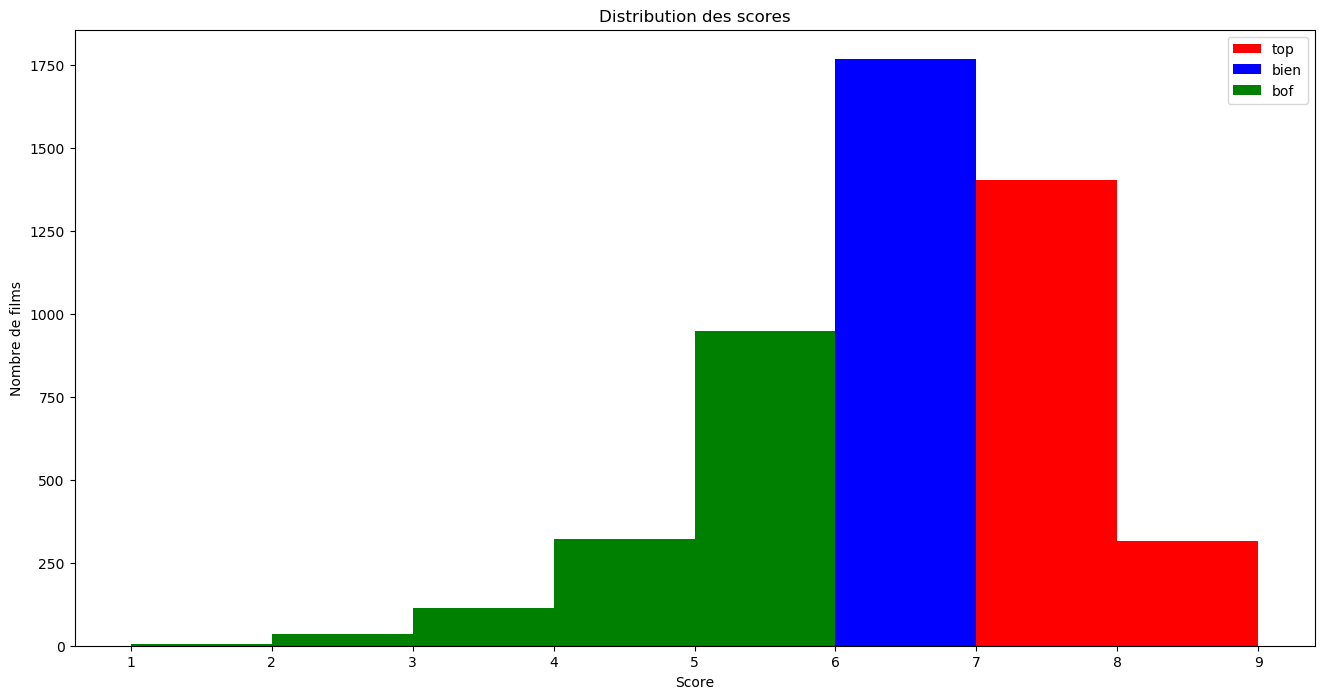

In [12]:
plt.figure(figsize=(16, 8))
plt.hist(df_num1.imdb_score, bins=range(1, 10), color='r', label='top')
plt.hist(df_num1[df_num1.imdb_score<7].imdb_score, bins=range(1, 10), color='b', label='bien')
plt.hist(df_num1[df_num1.imdb_score<6].imdb_score, bins=range(1, 10), color='g', label='bof')
plt.xlabel("Score")
plt.ylabel("Nombre de films")
plt.title("Distribution des scores")
plt.legend()

In [13]:
def GraphPCA(p_df):
    
    X = DropCol(p_df, 'imdb_score')
    p_X_norm = preprocessing.scale(X)

    # 2 directions principales pour l'affichage
    pca = decomposition.PCA(n_components=2)
    pca.fit(p_X_norm)
    print("Explained variance ratio :", pca.explained_variance_ratio_.cumsum())
    X_trans = pca.transform(p_X_norm)
    
    fig = plt.figure(figsize=(12, 5))
    # Avec 2 clusters
    cls = cluster.KMeans(n_clusters=2)
    cls.fit(p_X_norm)
    ax = fig.add_subplot(121)
    ax.scatter(X_trans[:, 0], X_trans[:, 1], c=cls.labels_)
    plt.title("2 clusters")
    # Avec 3 clusters
    cls3 = cluster.KMeans(n_clusters=3)
    cls3.fit(p_X_norm)
    ax = fig.add_subplot(122)
    ax.scatter(X_trans[:, 0], X_trans[:, 1], c=cls3.labels_)
    plt.title("3 clusters")

    fig = plt.figure(figsize=(12, 5))
    ax.scatter(X_trans[:, 0], X_trans[:, 1], c=cls3.labels_)
    # Avec les labels qu'on a défini plus haut
    ax = fig.add_subplot(122)
    ax.scatter(X_trans[:, 0], X_trans[:, 1], c=y)
    plt.title("3 groupes selon le score")
    
    print ("adjusted_rand_score :", metrics.adjusted_rand_score(y, cls3.labels_))

Explained variance ratio : [ 0.47059  0.66354]
adjusted_rand_score : 0.00741661499402


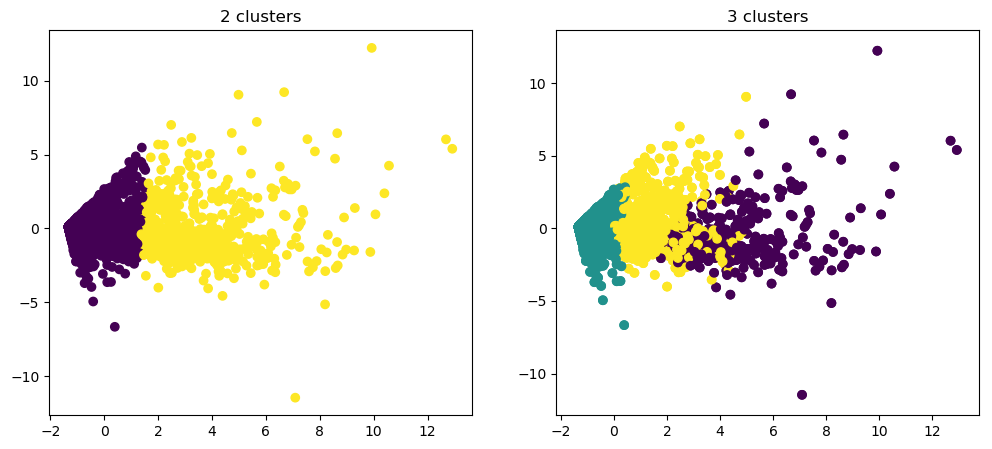

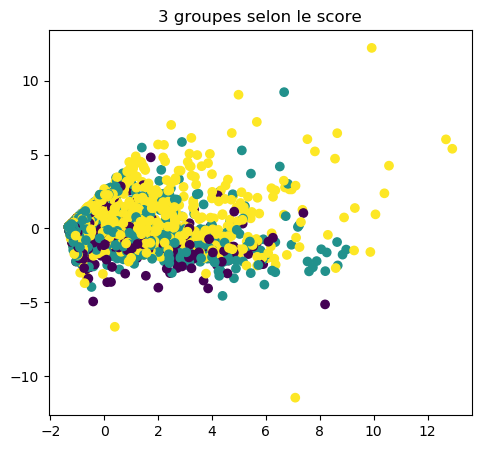

In [14]:
cols = ['color', 'duration', 'gross', 'aspect_ratio', 'budget', 'title_year', 'director_facebook_likes', 'actor_3_facebook_likes', 'num_voted_users', 'num_critic_for_reviews']
GraphPCA(df_num.drop(cols, axis=1))

Explained variance ratio : [ 0.13132  0.19942]
adjusted_rand_score : 0.0142281315678


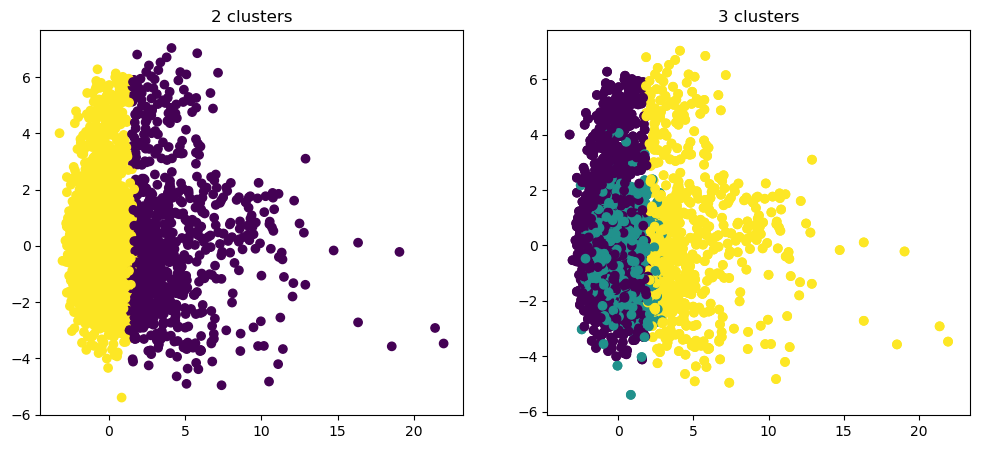

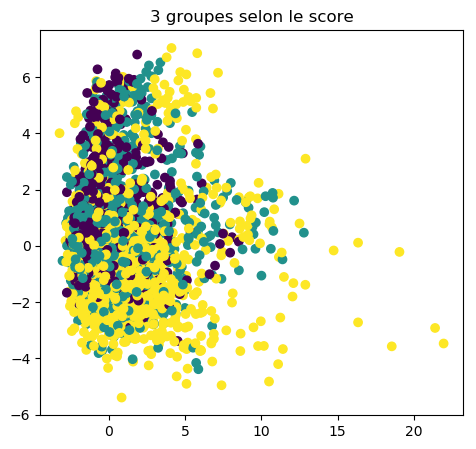

In [15]:
GraphPCA(df_num1)

Explained variance ratio : [ 0.00386  0.00609]
adjusted_rand_score : -0.000103892617559


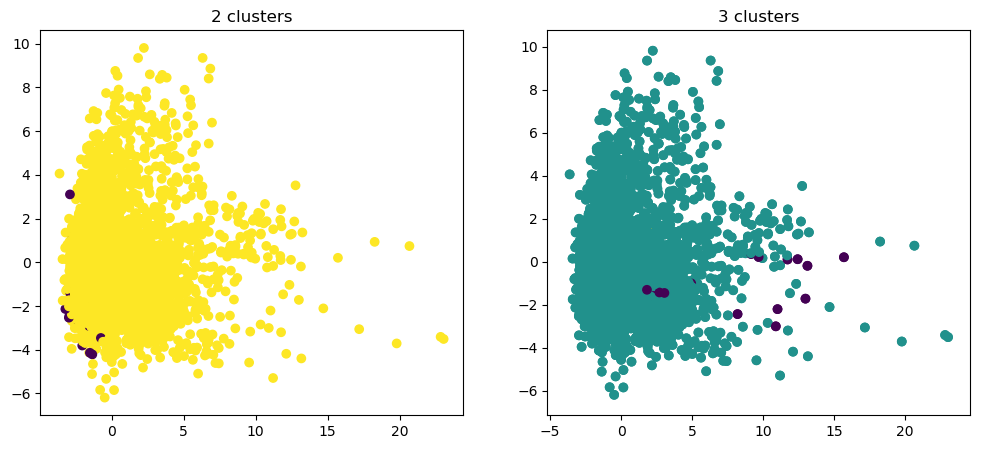

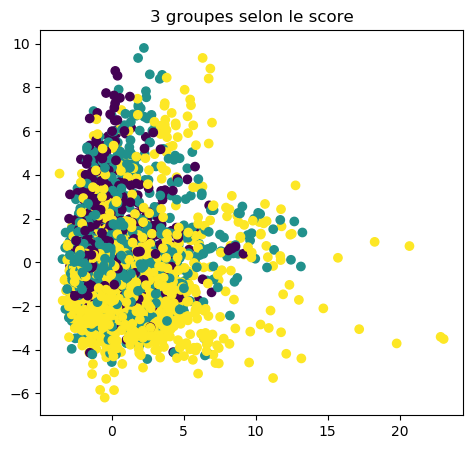

In [16]:
GraphPCA(df_num2)

Explained variance ratio : [ 0.00135  0.00238]
adjusted_rand_score : -5.35153060239e-05


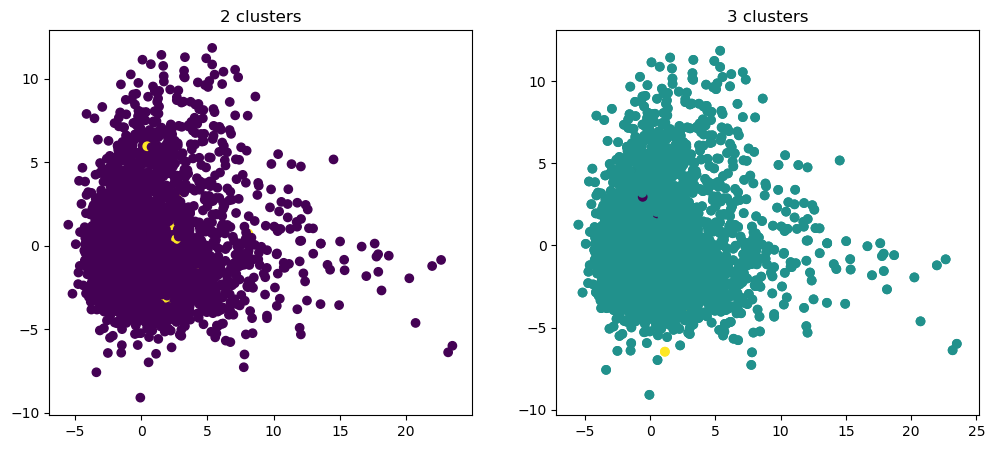

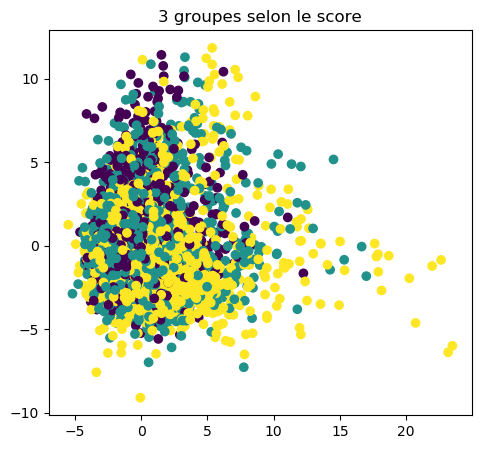

In [17]:
GraphPCA(df_num3)

## k-means et coefficients de silhouette

In [18]:
from sklearn import metrics, cluster, decomposition

In [19]:
def SilhouetteGraph(p_X_norm, p_num):
    sil = []
    nclust = range(2, 50)
    for nu in nclust:
        cls = cluster.KMeans(n_clusters=nu, n_init=1, init='random')
        cls.fit(p_X_norm)
        si = metrics.silhouette_score(p_X_norm, cls.labels_)
        sil.append(si)

    plt.figure(figsize=(10, 5))
    plt.plot(nclust, sil, marker='o')
    plt.xlabel("nb de clusters")
    plt.title("Coef de silhouette cas " + str(p_num))

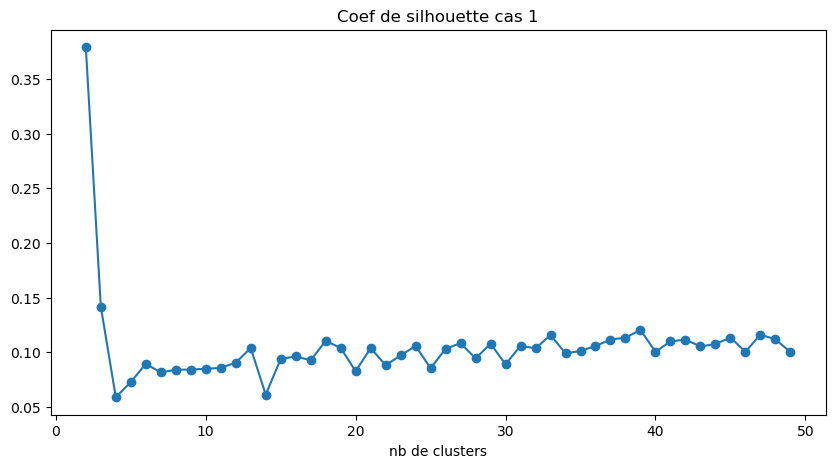

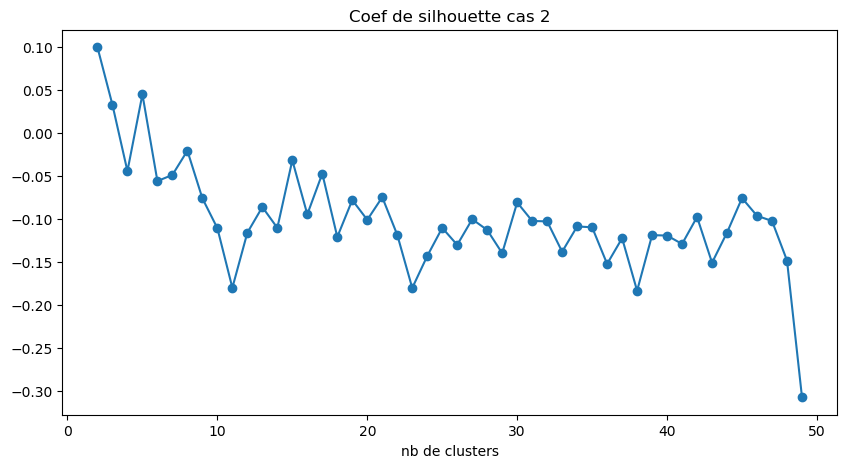

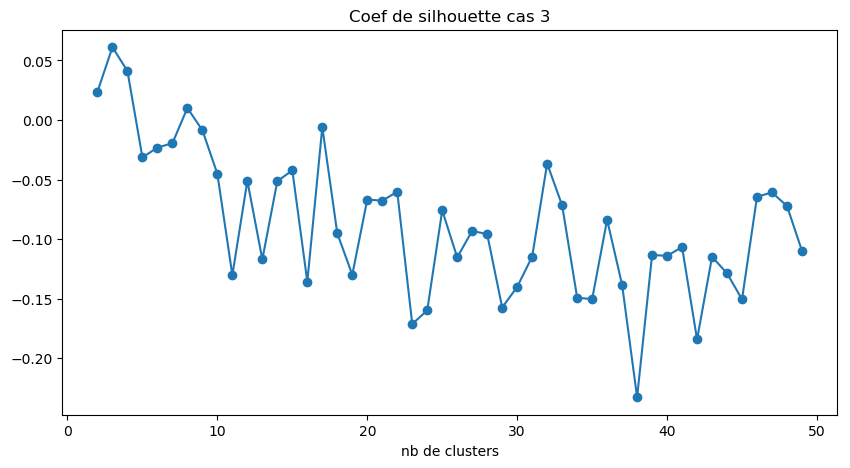

In [20]:
SilhouetteGraph(X_norm1, 1)
SilhouetteGraph(X_norm2, 2)
SilhouetteGraph(X_norm3, 3)

Text(0.5,1,'Coef de silhouette (sur les genres)')

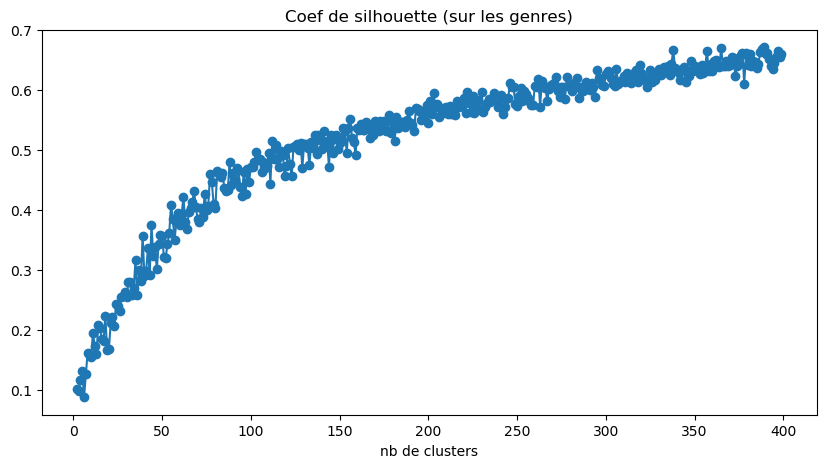

In [21]:
X_norm = preprocessing.scale(dfkeys1)
sil = []
nclust = range(2, 400)
for nu in nclust:
    cls = cluster.KMeans(n_clusters=nu, n_init=1, init='random')
    cls.fit(X_norm)
    si = metrics.silhouette_score(X_norm, cls.labels_)
    sil.append(si)

sil_genre=sil
plt.figure(figsize=(10, 5))
plt.plot(range(2, len(sil_genre)+2), sil_genre, marker='o')
plt.xlabel("nb de clusters")
plt.title("Coef de silhouette (sur les genres)")

Text(0.5,1,'Coefficients de silhouette')

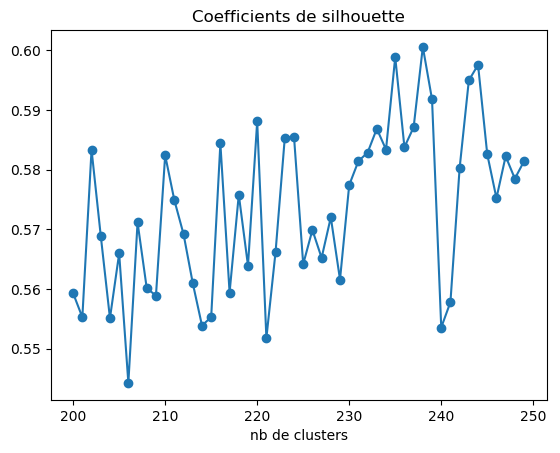

In [22]:
sil = []
nclust = range(200, 250, 1)
for nu in nclust:
    cls = cluster.KMeans(n_clusters=nu, n_init=1, init='random')
    cls.fit(X_norm)
    si = metrics.silhouette_score(X_norm, cls.labels_)
    sil.append(si)
    
plt.plot(nclust, sil, marker='o')
plt.xlabel("nb de clusters")
plt.title("Coefficients de silhouette")

## Dendrogrammes

### Coefficient de corrélation cophénetique

In [24]:
from scipy.cluster.hierarchy import cophenet, linkage
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(linkage(X_norm1, 'ward'), pdist(X_norm1))
print (c, '(ward cas 1)')
c, coph_dists = cophenet(linkage(X_norm2, 'ward'), pdist(X_norm2))
print (c, '(ward cas 2)')
c, coph_dists = cophenet(linkage(X_norm3, 'ward'), pdist(X_norm3))
print (c, '(ward cas 3)')
c, coph_dists = cophenet(linkage(X_norm1, 'single'), pdist(X_norm1))
print (c, '(single cas 1)')
c, coph_dists = cophenet(linkage(X_norm1, 'complete'), pdist(X_norm1))
print (c, '(complete cas 1)')
c, coph_dists = cophenet(linkage(X_norm1, 'average'), pdist(X_norm1))
print (c, '(average cas 1)')
c, coph_dists = cophenet(linkage(X_norm1, 'weighted'), pdist(X_norm1))
print (c, '(weighted cas 1)')
c, coph_dists = cophenet(linkage(X_norm1, 'centroid'), pdist(X_norm1))
print (c, '(centroid cas 1)')
c, coph_dists = cophenet(linkage(X_norm1, 'median'), pdist(X_norm1))
print (c, '(median cas 1)')

0.407421887946 (ward cas 1)
0.308408691719 (ward cas 2)
0.693663848476 (ward cas 3)
0.863821647373 (single cas 1)
0.837504294484 (complete cas 1)
0.921494559025 (average cas 1)
0.811724690551 (weighted cas 1)
0.916370756587 (centroid cas 1)
0.86868447764 (median cas 1)


In [25]:
coph_dists

array([ 20.64851,  20.64851,  16.21857, ...,   4.92673,   9.02033,
         9.02033])

### Affichage des dendrogrammes

In [26]:
from scipy.cluster.hierarchy import dendrogram, linkage

def DendroGraph(p_X_norm, p_num):
    # Matrice de distance
    Z = linkage(p_X_norm, 'ward')
    # Affichage du dendrogramme
    plt.figure(figsize=(20, 10))
    plt.title("Dendrogramme cas " + str(p_num))
    plt.xlabel('index')
    plt.ylabel('distance')
    dendrogram(
        Z,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=30,  # show only the last p merged clusters
        #show_leaf_counts=False,  # otherwise numbers in brackets are counts
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True,  # to get a distribution impression in truncated branches
    )
    plt.show()

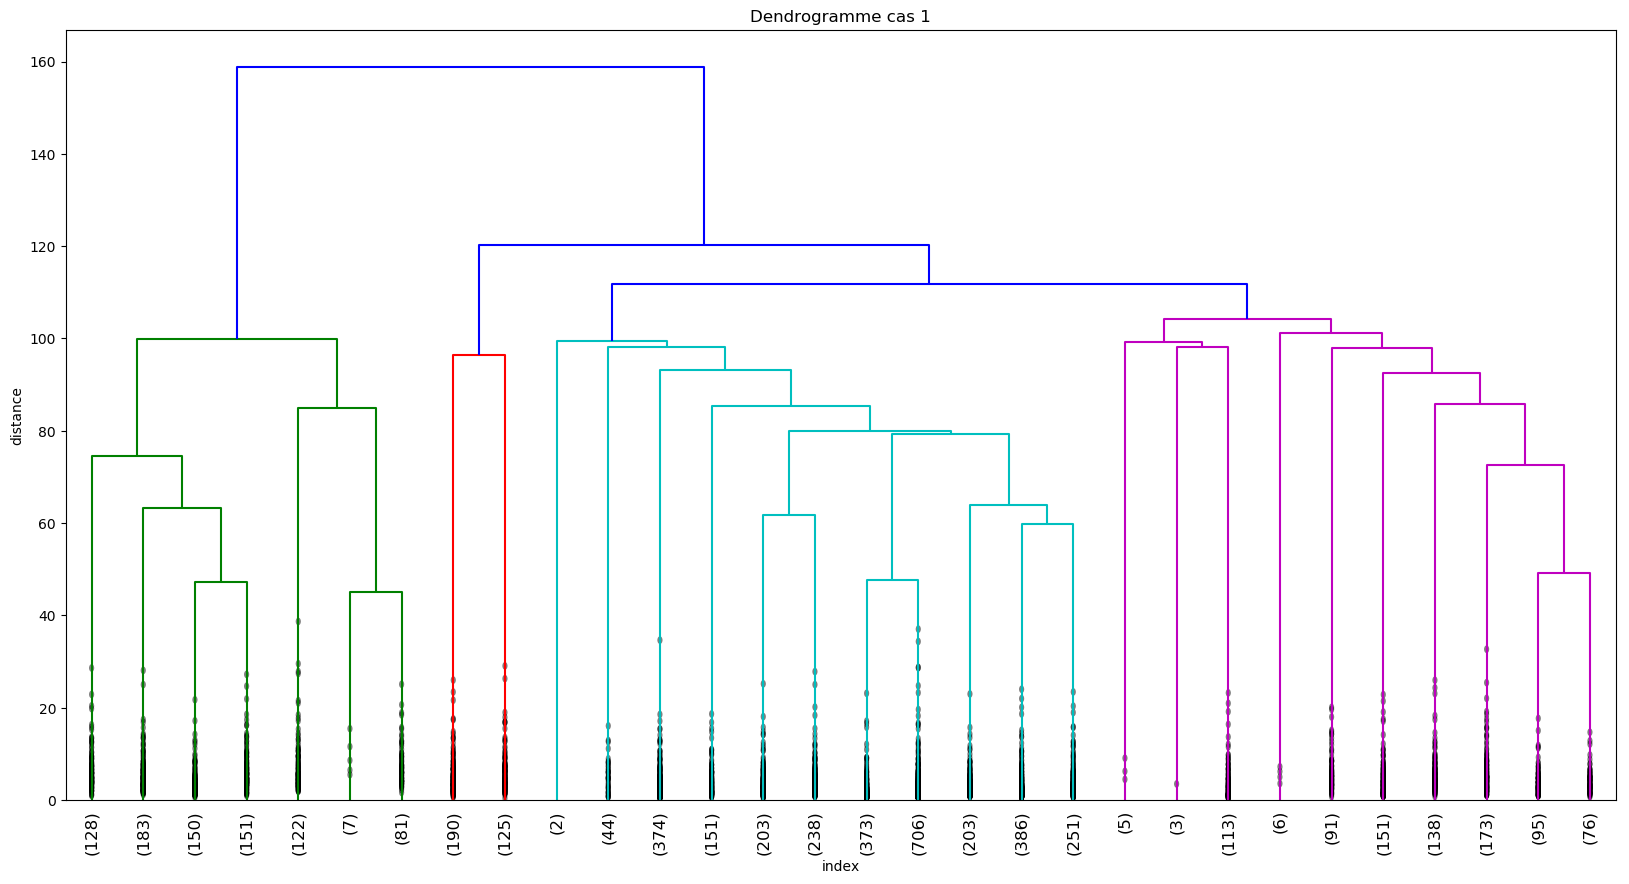

In [27]:
DendroGraph(X_norm1, 1)

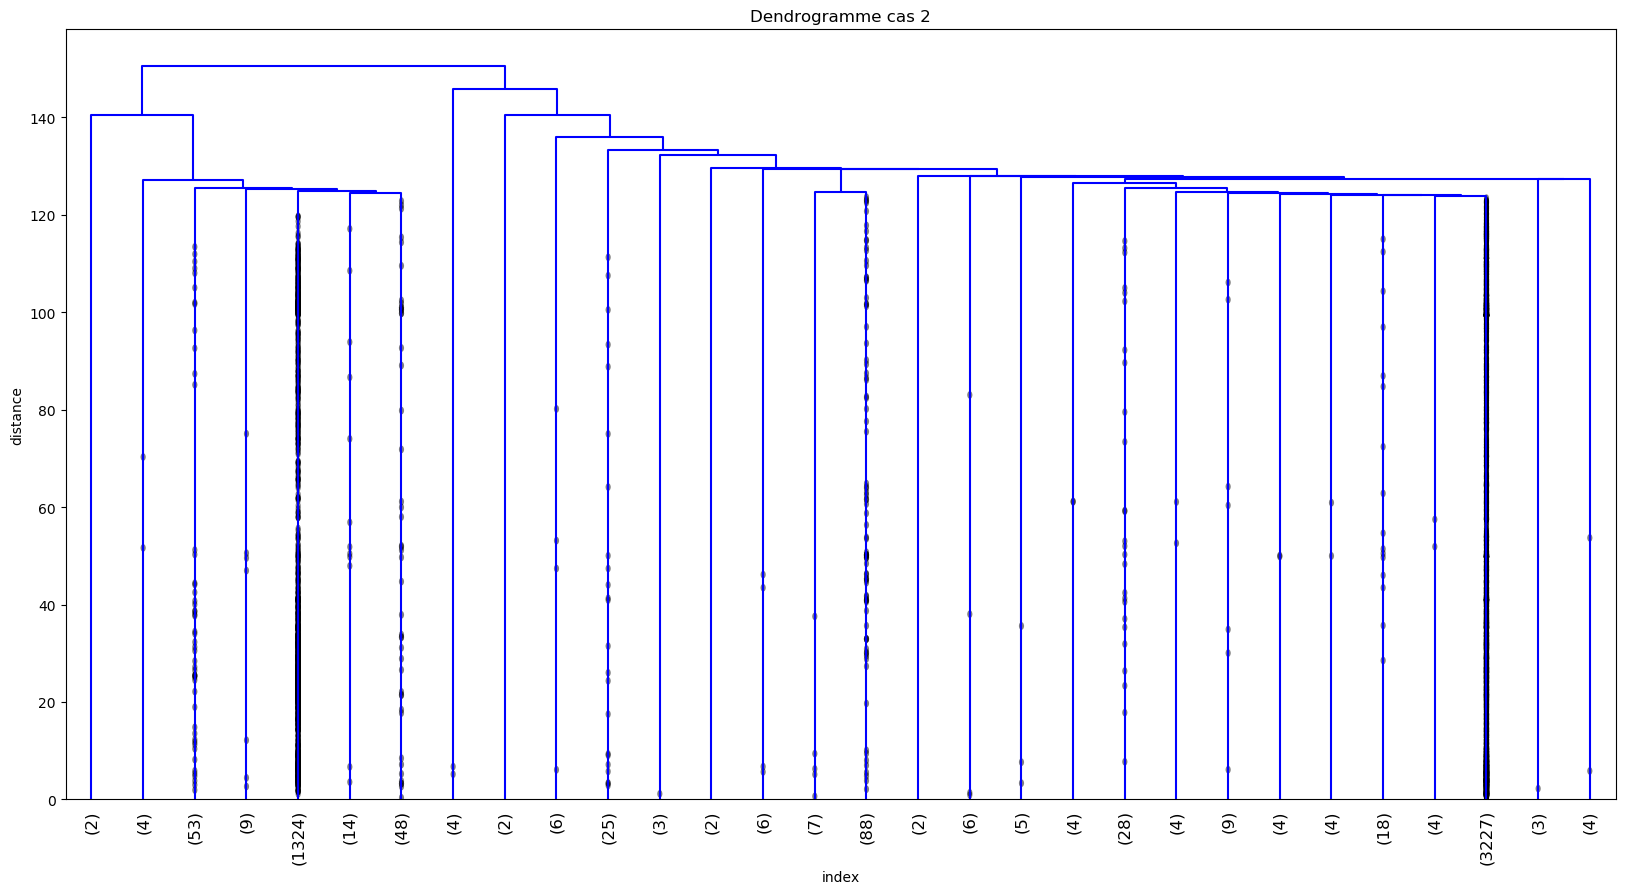

In [28]:
DendroGraph(X_norm2, 2)

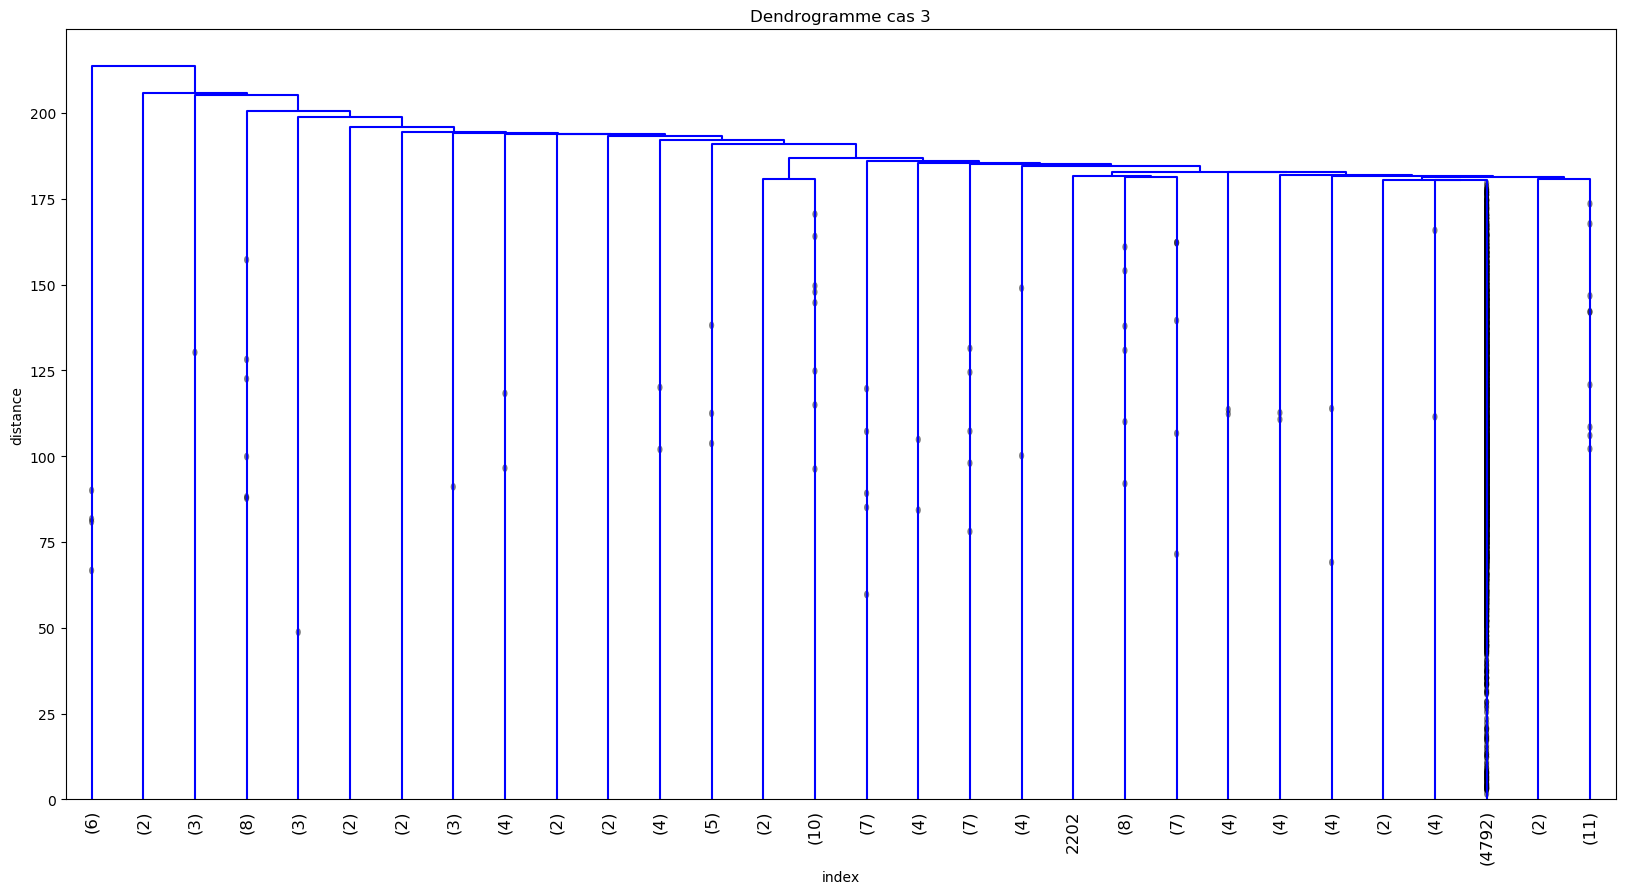

In [29]:
DendroGraph(X_norm3, 3)

In [ ]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

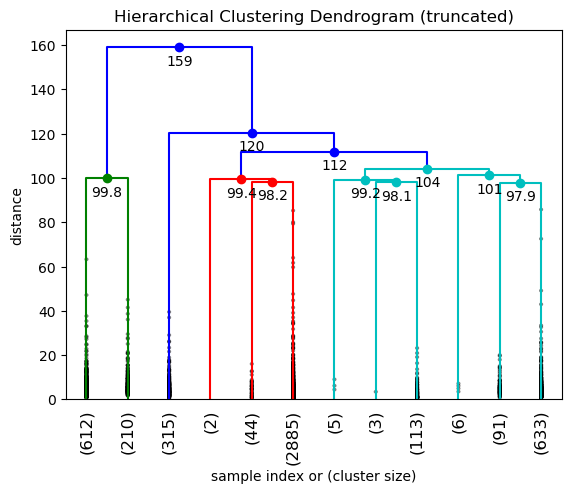

In [37]:
Z = linkage(X_norm1, 'ward')
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

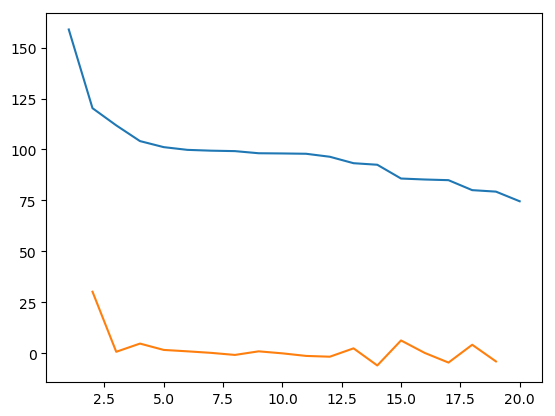

clusters: 2


In [38]:
# Détermination de k (elbow méthode)
last = Z[-20:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:", k)


## Calculs de distances

### Quelques méthodes

In [39]:
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel, chi2_kernel

In [40]:
# Méthode qui analyse une matrice de distances et renvoie un classement 
iStock = 10
def CalcSimilarities(similarities):
    results = {}
    for idx, row in df.iterrows():
        # On garde les meilleurs résultats (moins l'item lui-même)
        similar_indices = similarities[idx].argsort()[-2:-(iStock+2):-1]
        similar_items = [(similarities[idx][i], df.movie_title[i]) for i in similar_indices]
        #similar_items = [(similarities[idx][i], df.movie_title[i], df[df.movie_title==df.movie_title[i]].index.values[0]) for i in similar_indices]
        # Et on met la clé en minuscule pour la recherche
        results[row['movie_title'].lower()] = similar_items
    print("Done!")
    return results

In [41]:
from sklearn.neighbors import DistanceMetric
def gower_distance(X):
    """
    Nominal variables: Dice distance (https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)
    Numeric variables: Manhattan distance normalized by the range of the variable (https://en.wikipedia.org/wiki/Taxicab_geometry)
    """
    individual_variable_distances = []

    for i in range(X.shape[1]):
        feature = X.iloc[:,[i]]
        if feature.dtypes[0] == np.object:
            feature_dist = DistanceMetric.get_metric('dice').pairwise(pd.get_dummies(feature))
        else:
            feature_dist = DistanceMetric.get_metric('manhattan').pairwise(feature) / np.ptp(feature.values)

        individual_variable_distances.append(feature_dist)

    return np.array(individual_variable_distances).mean(0)

### Calculs

In [42]:
# On peut tester avec la 1ère distance
rescosine1 = CalcSimilarities(cosine_similarity(X_norm1))
rescosine2 = CalcSimilarities(cosine_similarity(X_norm2))
rescosine3 = CalcSimilarities(cosine_similarity(X_norm3))

Done!
Done!
Done!


In [43]:
# Autre distance
reslinear1 = CalcSimilarities(linear_kernel(X_norm1))
reslinear2 = CalcSimilarities(linear_kernel(X_norm2))
reslinear3 = CalcSimilarities(linear_kernel(X_norm3))

Done!
Done!
Done!


In [44]:
# Autre calcul (si le nombre de colonnes n'est pas trop grand)
if df_num.shape[1] < 2000:
    # Avec le scaler entre 0 et 1
    scaler = preprocessing.MinMaxScaler().fit(df_num)
    X_norm01 = scaler.transform(df_num)

    chi2_similarities = chi2_kernel(X_norm01)
    print(chi2_similarities.shape)

    reschi2 = CalcSimilarities(chi2_similarities)

(4919, 4919)
Done!


In [45]:
# Gower
gower_similarities = gower_distance(df)
resgower = CalcSimilarities(1 -gower_similarities)

Done!


### Tests de pertinence

In [46]:
testfilm = 'shrek'
testfilm = "modern times"
testfilm = 'men in black'
testfilm = 'rush hour'
testfilm = 'spider-man'
testfilm = 'saw'
rescosine1[testfilm]

[(0.89461312258408088, 'The Grudge'),
 (0.87172927132151734, 'Saw II'),
 (0.86562690088658445, 'Scream'),
 (0.83448540033684027, 'Jeepers Creepers'),
 (0.82406110372705899, 'Orphan'),
 (0.80727868251676504, 'Stir of Echoes'),
 (0.80324514965251326, 'Silent Hill'),
 (0.79839412728777093, 'Saw III'),
 (0.78683364637828213, 'House on Haunted Hill'),
 (0.78651335763775954, 'Devil')]

In [47]:
rescosine2[testfilm]

[(0.81641649772651004, 'Batman: The Dark Knight Returns, Part 2'),
 (0.67445756279535218, 'The Legend of Zorro'),
 (0.53905189360234085, 'Death Sentence'),
 (0.42975829133675758, 'Furious 7'),
 (0.37879136447632433, 'Insidious'),
 (0.37283622862386667, 'Insidious: Chapter 2'),
 (0.30582958691269441, 'The Conjuring 2'),
 (0.26443701611672343, 'The Conjuring'),
 (0.093549316364012189, 'Unfriended'),
 (0.089795415043537663, 'It Follows')]

In [48]:
rescosine3[testfilm]

[(0.31825089450491578, 'Batman: The Dark Knight Returns, Part 2'),
 (0.262406800450181, 'The Legend of Zorro'),
 (0.19298699208727549, 'The Last House on the Left'),
 (0.18012403123599227, 'Insidious'),
 (0.17325723137165847, 'Saw II'),
 (0.1727260656103404, 'Con Air'),
 (0.16601487697119496, 'Patch Adams'),
 (0.16265236712125267, 'Open Road'),
 (0.15845639382422455, 'Furious 7'),
 (0.15481480844733658, 'Without Limits')]

In [49]:
reslinear1[testfilm]

[(52.519644892015258, 'The Lord of the Rings: The Fellowship of the Ring'),
 (51.704084085775399, 'The Shawshank Redemption'),
 (43.18084133235719, 'The Matrix'),
 (42.572959995436811, 'The Blair Witch Project'),
 (41.487670657256103, 'Saw'),
 (40.19970798678218, 'Memento'),
 (38.420944067655782, 'The Sixth Sense'),
 (37.220204349307203, 'The Lord of the Rings: The Return of the King'),
 (37.069256727323705, 'Fight Club'),
 (35.981822249038537, 'Psycho')]

In [50]:
reslinear2[testfilm]

[(1638.3264305996129, 'Batman: The Dark Knight Returns, Part 2'),
 (1631.8516537661624, 'The Legend of Zorro'),
 (735.45666622894487, 'The Conjuring'),
 (732.99707068649889, 'Insidious'),
 (727.76673450915769, 'The Conjuring 2'),
 (716.8021199042629, 'Insidious: Chapter 2'),
 (705.71756476322184, 'Death Sentence'),
 (704.8048385139233, 'Furious 7'),
 (55.887532284533663, 'The Dark Knight'),
 (50.035388568145244, 'The Lord of the Rings: The Fellowship of the Ring')]

In [51]:
reslinear3[testfilm]

[(1633.4006665987581, 'Batman: The Dark Knight Returns, Part 2'),
 (1624.1781318361091, 'The Legend of Zorro'),
 (946.88666015674335, 'Saw II'),
 (838.91443254671117, 'Saw III'),
 (836.17537283975844, 'Saw IV'),
 (833.03790184880302, 'Saw VI'),
 (807.65412053991702, 'Grace Unplugged'),
 (731.00007535525936, 'The Conjuring'),
 (725.0386732599269, 'Insidious'),
 (723.31076389909583, 'The Conjuring 2')]

In [52]:
if df_num.shape[1] < 2000:
    for it in reschi2[testfilm]:
        print(it)

(0.94065240519138926, 'Napoleon Dynamite')
(0.90693697985415567, 'Saw II')
(0.89971109093224633, 'Hostel')
(0.89660640500600963, 'Crash')
(0.87985277734234413, 'Halloween')
(0.85660156932193909, 'The Mist')
(0.84925792086849816, 'The Hills Have Eyes')
(0.84162709731203489, 'Sideways')
(0.84013230694577035, 'Dawn of the Dead')
(0.83924124803928812, 'Cloverfield')


In [53]:
resgower[testfilm]

[(0.77780034192426828, 'The Conjuring 2'),
 (0.76847584055520213, 'The Conjuring'),
 (0.75927334483981113, 'Saw II'),
 (0.75046573130836614, 'Orphan'),
 (0.74964832704769602, 'The Last House on the Left'),
 (0.74600806336851522, 'Stir of Echoes'),
 (0.74465125424903533, 'Death Sentence'),
 (0.74174208367304995, 'Unfriended'),
 (0.74024868180480041, 'House on Haunted Hill'),
 (0.73981054233399646, 'Deliver Us from Evil')]

## Sauvegarde pour le service web

In [54]:
# Save
np.save('RecommendingResult.npy', rescosine2)

In [ ]:
# Load
#results2 = np.load('RecommendingResult.npy').item()